In [15]:
import sys
import numpy as np
import os
import cv2
import h5py
import logging
import tensorflow as tf
from math import log10
from collections import OrderedDict

import matplotlib.pyplot as plt
from typing import Iterator, Tuple
from shapeSorter import SimpleSegmentationDataset
from layers import weight_variable,bias_variable,conv2d,weight_variable_devonc,deconv2d,max_pool,pixel_wise_softmax,cross_entropy,features_concat,pixel_wise_softmax_2

In [16]:
##########
GLOBAL_PATH='MODEL_SHAPE/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        

##############

        
INPUT_CHANNELS=3
OUTPUT_CHANNELS=3
NB_CLASSES=3

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'SRCNN.ckpt'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=250
DROPOUT=0.9#0.8
DEFAULT_BATCH_SIZE = 10#50
DEFAULT_EPOCHS = 15#5
DEFAULT_ITERATIONS =490#98
DEFAULT_VALID=30#70
DISPLAY_STEP=50

In [17]:
def create_conv_net(x, keep_prob, channels, n_class, layers=4, features_root=32, filter_size=3, pool_size=2,phase_train=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    """

    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]),'reshape_for_network')
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []

    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    
    in_size = 1000
    size = in_size
    
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))

        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        

        conv1 = conv2d(in_node, w1, keep_prob)
        conv1=tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=phase_train)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        conv2=tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=phase_train)
        conv2=conv2+conv1
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2,layer))
        biases.append((b1, b2,layer))
        convs.append((conv1, conv2))

        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]

    # up layers
    for layer in range(layers-2, -1, -1):
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = features_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        conv1=tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=phase_train)
        h_conv = tf.nn.relu(conv1 + b1)
        conv2 = conv2d(h_conv, w2, keep_prob)
        conv2=tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=phase_train)
        conv2=conv2+conv1
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2,layer))
        biases.append((b1, b2,layer))
        convs.append((conv1, conv2))
        
        size *= 2


    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
#     conv=tf.contrib.layers.batch_norm(conv, center=True, scale=True, is_training=phase_train)
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    

    variables = []
    for w1,w2,layer in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2,layer in biases:
        variables.append(b2)
        variables.append(b2)
    

    
    return output_map, variables, int(in_size - size)



In [18]:
class CustomCNN():
    
    def __init__(self, channels=3, n_class=3, cost_kwargs={}, **kwargs):
        """
        Initializes the custom CNN 
        """
        self.n_class = n_class
        tf.reset_default_graph()
        
        self.X_placeholder = tf.placeholder(tf.float32, [None, None, None, INPUT_CHANNELS], name='X_placeholder')
        self.y_placeholder = tf.placeholder(tf.float32, [None, None, None,NB_CLASSES], name='y_placeholder')
        self.keep_prob = tf.placeholder(tf.float32)
        self.phase_train = tf.placeholder(tf.bool, name='phase_train')

        logits, self.variables, self.offset = create_conv_net(self.X_placeholder, self.keep_prob, channels, n_class, **kwargs)
        
       
        
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y_placeholder, [-1, n_class]),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class])))
        self.cost=self.cross_entropy
#         self.gradients_node = tf.gradients(self.cross_entropy, self.variables)
                                                  
        self.predicter = pixel_wise_softmax_2(logits)
        self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y_placeholder, 3))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
        
    def save(self, sess,saver, model_path,step):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param saver: saver of the model
        :param model_path: path to file system location
        :step: step of the iterations during training when the model is stored
        """
       
        save_path=saver.save(sess, model_path,global_step=step)
        
        return save_path

    
    def restore(self, sess,saver, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param saver: saver of the model
        :param model_path: path to file system checkpoint location
        """

        print("Reading checkpoints...")
        saver.restore(sess, model_path)
        summary="Model restored from file: %s" % (model_path)
        print(summary)
        return True
        
    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.X_placeholder: x_test, self.y_placeholder: y_dummy, self.keep_prob: 1.})
            
        return prediction
        
        
       

In [19]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer ->learning_rate, decay_rate,momentum (momentum) or learning_rate (adam)   
    """
    def __init__(self, net, batch_size=30, optimizer="adam", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        self.learning_rate_ph=tf.placeholder(tf.float32, shape=[])
        self.learning_rate=0.0001
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.0001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,global_step=global_step)
        elif self.optimizer=="gradient_descent":
            optimizer =tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate_ph).minimize(self.net.cost)
       
        return optimizer
    
    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0)
        
#         self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))

        self.optimizer = self._get_optimizer(training_iters, global_step)        
        init = tf.global_variables_initializer()
        
        self.prediction_path = prediction_path
        
        
        
        
        return init
    
    def train(self, data_provider_path, save_path='', restore_path='', training_iters=4, epochs=3, dropout=0.75, display_step=1, validation_batch_size=30,restore=False,rec_save=1, prediction_path = ''):
        """
        Lauches the training process
        
        :param data_provider_path: where the DATASET folder is
        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """

        #STORE PSNR for ANALYSIS
        loss_train=np.zeros(training_iters*epochs)
        file_train = open(data_provider_path+'loss_train.txt','w') 
        loss_verif=np.zeros(epochs)
        file_verif = open(data_provider_path+'loss_verif.txt','w') 
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        init = self._initialize(training_iters, save_path, restore, prediction_path)
        saver = tf.train.Saver()
        with tf.Session() as sess:        
            sess.run(init)
            
            if restore:
                self.net.restore(sess,saver,restore_path )
            else:
                sess.run(init)

            val_generator=SimpleSegmentationDataset(SIZE_PATCH,NB_CLASSES,virtual_size=validation_batch_size)
            X_val,Y_val=val_generator.__getitem__()

#             X_val=standardize(X_val)


            self.store_prediction(sess, X_val, Y_val, "_init",validation_batch_size)
        
            train_len = self.batch_size*training_iters

            training_generator=SimpleSegmentationDataset(SIZE_PATCH,NB_CLASSES,virtual_size=train_len)
            X_train,Y_train=training_generator.__getitem__()
                
            logging.info("Start optimization")
            
#             avg_gradients = None
            counter=0
            for epoch in range(epochs):
                total_loss = 0

                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    
                    step_batch=step-(epoch*training_iters)
                    batch_x= X_train[step_batch*self.batch_size:(step_batch+1)*self.batch_size]
                    batch_y =Y_train[step_batch*self.batch_size:(step_batch+1)*self.batch_size]
#                     batch_x=standardize(batch_x)
                    
                    # Run optimization op (backprop)
#                   _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
#                                                       feed_dict={self.net.X_placeholder: batch_x,
#                                                                  self.net.y_placeholder: batch_y,
#                                                                  self.net.keep_prob: dropout,self.net.phase_train:True})
                    _, loss, lr = sess.run((self.optimizer, self.net.cost, self.learning_rate_node), 
                                                      feed_dict={self.net.X_placeholder: batch_x,
                                                                 self.net.y_placeholder: batch_y,
                                                                 self.net.keep_prob: dropout,
                                                                 self.learning_rate_ph:self.learning_rate,
                                                                 self.net.phase_train:True})
#                     _, loss= sess.run((self.optimizer, self.net.cost), 
#                                                       feed_dict={self.net.X_placeholder: batch_x,
#                                                                  self.net.y_placeholder: batch_y,
#                                                                  self.net.keep_prob: dropout,
#                                                                  self.learning_rate_ph:self.learning_rate,
#                                                                  self.net.phase_train:True})

#                     avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
#                     norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
#                     self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, step, batch_x,batch_y)
                        
                    total_loss += loss
                    loss_train[counter]=loss
                    file_train.write(str(loss_train[counter])+'\n')
                    counter += 1
                    if counter % rec_save == 0:
                        save_path=self.net.save(sess,saver,save_path, counter)
                        
                    
#                 self.output_epoch_stats(epoch, total_loss, training_iters, self.learning_rate)
                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                
                loss_v=self.store_prediction(sess, X_val, Y_val, "epoch_%s"%epoch,validation_batch_size)
                loss_verif[epoch]=loss_v
                file_verif.write(str(loss_verif[epoch])+'\n')
                
            logging.info("Optimization Finished!")
            
            return save_path, loss_train,loss_verif
        
    def store_prediction(self, sess, batch_x, batch_y, name,validation_batch_size):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.X_placeholder: batch_x, 
                                                             self.net.y_placeholder: batch_y, 
                                                             self.net.keep_prob: 1.,
                                                             self.net.phase_train:False})

        loss,accuracy = sess.run((self.net.cost,self.net.accuracy), feed_dict={self.net.X_placeholder: batch_x, 
                                                       self.net.y_placeholder: batch_y, 
                                                       self.net.keep_prob: 1.,
                                                  self.net.phase_train:False})
        if accuracy>=0.80 :
            self.learning_rate=0.00001

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,batch_y),loss))
        
        plot_summary(prediction,batch_y,validation_batch_size,name,self.prediction_path)
        return loss

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        loss, acc, predictions = sess.run([self.net.cost,self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.X_placeholder: batch_x,
                                                                      self.net.y_placeholder: batch_y,
                                                                      self.net.keep_prob: 1.,
                                                                      self.net.phase_train:False})
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                                    loss,
                                                                                                                    acc,
                                                                                                                    error_rate(predictions, batch_y)))

In [20]:
def standardize(data):
    '''
    Standardize the input data of the network
    :param data to be standardized (size nb_batches x WIDTH x HEIGHT x number of channels) 
    
    returns data standardized size nb_batches x WIDTH x HEIGHT x number of channels 
    
    '''
    WIDTH=data.shape[1]
    HEIGHT=data.shape[2]
    channels=data.shape[3]
    
    mean_t=np.mean(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    std_t=np.std(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=data-mean_t/std_t
    
    #For normalization 
    min_t=np.amin(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    max_t=np.amax(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=(data-min_t)/(max_t-min_t)

    return data

def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """
    
    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,batch_size,epoch,prediction_path):
    
    
    fig1, axs1 = plt.subplots(1, batch_size,figsize=(8*batch_size,8))
    suptitle = fig1.suptitle(epoch+' Groundtruth ', fontsize='large')
    fig2, axs2 = plt.subplots(1, batch_size,figsize=(batch_size*8,8))
    suptitle2 = fig2.suptitle(epoch+' Predictions ', fontsize='large')
    labels=np.argmax(labels, 3)
    logits=np.argmax(predictions, 3)
    for i in range(batch_size):  
        axs1[i].imshow(labels[i,:,:])
        plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i,:,:]) 
        axs2[i].imshow(1-logits[i,:,:])
        plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',labels[i,:,:])

    plt.subplots_adjust()
#     suptitle.set_y(0.95)
#     fig.subplots_adjust(top=0.96)
    plt.show()
    plt.show()

# def _update_avg_gradients(avg_gradients, gradients, step):
#     if avg_gradients is None:
#         avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
#     for i in range(len(gradients)):
#         avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
        
#     return avg_gradients


2018-03-10 19:19:05,852 Layers 4, features 32, filter size 3x3, pool size: 2x2
2018-03-10 19:19:09,050 Verification error= 9.3%, loss= 0.0723


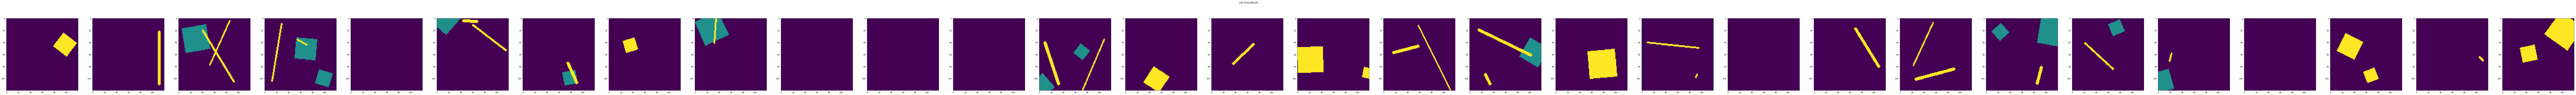

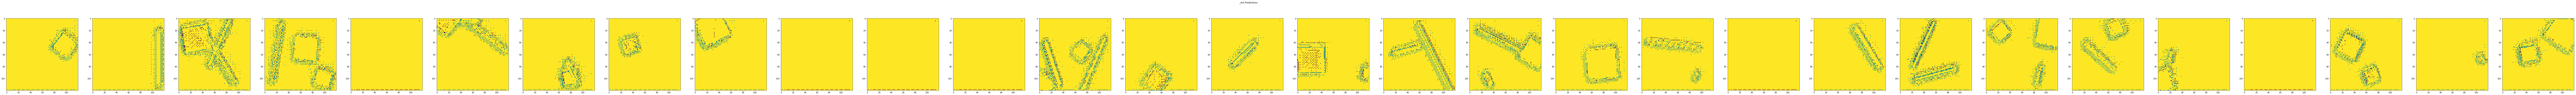

2018-03-10 19:19:23,769 Start optimization
2018-03-10 19:19:24,169 Iter 0, Minibatch Loss= 0.1002, Training Accuracy= 0.8845, Minibatch error= 11.5%
2018-03-10 19:19:27,634 Iter 50, Minibatch Loss= 0.0710, Training Accuracy= 0.9335, Minibatch error= 6.6%
2018-03-10 19:19:31,124 Iter 100, Minibatch Loss= 0.0664, Training Accuracy= 0.9394, Minibatch error= 6.1%
2018-03-10 19:19:34,645 Iter 150, Minibatch Loss= 0.0460, Training Accuracy= 0.9151, Minibatch error= 8.5%
2018-03-10 19:19:38,200 Iter 200, Minibatch Loss= 0.0718, Training Accuracy= 0.8258, Minibatch error= 17.4%
2018-03-10 19:19:42,533 Iter 250, Minibatch Loss= 0.0576, Training Accuracy= 0.6565, Minibatch error= 34.3%
2018-03-10 19:19:46,077 Iter 300, Minibatch Loss= 0.0565, Training Accuracy= 0.7148, Minibatch error= 28.5%
2018-03-10 19:19:49,616 Iter 350, Minibatch Loss= 0.0448, Training Accuracy= 0.9551, Minibatch error= 4.5%
2018-03-10 19:19:53,172 Iter 400, Minibatch Loss= 0.0421, Training Accuracy= 0.8474, Minibatch error

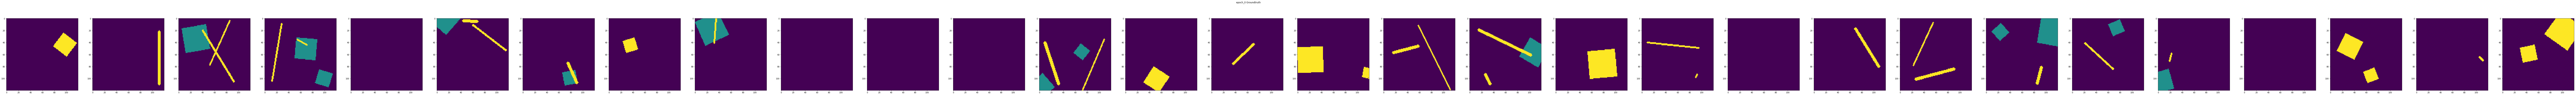

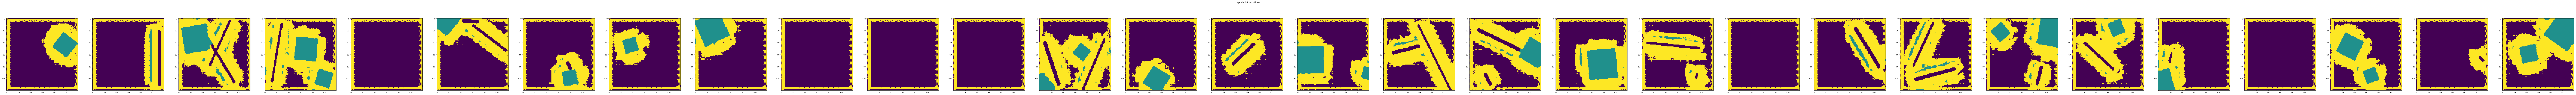

2018-03-10 19:20:09,512 Iter 500, Minibatch Loss= 0.0458, Training Accuracy= 0.6685, Minibatch error= 33.1%
2018-03-10 19:20:13,075 Iter 550, Minibatch Loss= 0.0439, Training Accuracy= 0.8495, Minibatch error= 15.1%
2018-03-10 19:20:16,636 Iter 600, Minibatch Loss= 0.0487, Training Accuracy= 0.9669, Minibatch error= 3.3%
2018-03-10 19:20:20,373 Iter 650, Minibatch Loss= 0.0466, Training Accuracy= 0.9728, Minibatch error= 2.7%
2018-03-10 19:20:24,112 Iter 700, Minibatch Loss= 0.0460, Training Accuracy= 0.5584, Minibatch error= 44.2%
2018-03-10 19:20:28,626 Iter 750, Minibatch Loss= 0.0496, Training Accuracy= 0.7906, Minibatch error= 20.9%
2018-03-10 19:20:32,302 Iter 800, Minibatch Loss= 0.0432, Training Accuracy= 0.8841, Minibatch error= 11.6%
2018-03-10 19:20:36,032 Iter 850, Minibatch Loss= 0.0624, Training Accuracy= 0.9697, Minibatch error= 3.0%
2018-03-10 19:20:39,769 Iter 900, Minibatch Loss= 0.0522, Training Accuracy= 0.8371, Minibatch error= 16.3%
2018-03-10 19:20:43,506 Iter 95

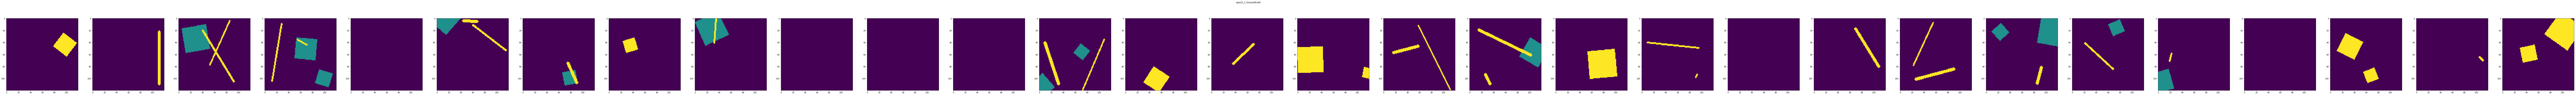

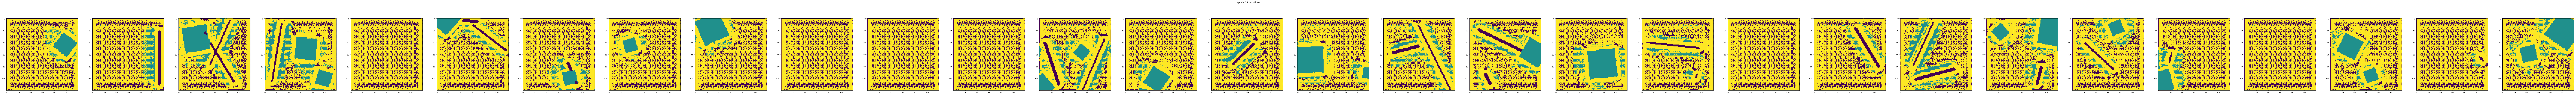

2018-03-10 19:20:56,694 Iter 1000, Minibatch Loss= 0.0436, Training Accuracy= 0.9211, Minibatch error= 7.9%
2018-03-10 19:21:00,248 Iter 1050, Minibatch Loss= 0.0540, Training Accuracy= 0.9475, Minibatch error= 5.3%
2018-03-10 19:21:03,942 Iter 1100, Minibatch Loss= 0.0428, Training Accuracy= 0.9482, Minibatch error= 5.2%
2018-03-10 19:21:07,696 Iter 1150, Minibatch Loss= 0.0422, Training Accuracy= 0.8651, Minibatch error= 13.5%
2018-03-10 19:21:11,444 Iter 1200, Minibatch Loss= 0.0384, Training Accuracy= 0.7845, Minibatch error= 21.5%
2018-03-10 19:21:15,983 Iter 1250, Minibatch Loss= 0.0482, Training Accuracy= 0.9457, Minibatch error= 5.4%
2018-03-10 19:21:19,703 Iter 1300, Minibatch Loss= 0.0494, Training Accuracy= 0.9883, Minibatch error= 1.2%
2018-03-10 19:21:23,444 Iter 1350, Minibatch Loss= 0.0313, Training Accuracy= 0.6586, Minibatch error= 34.1%
2018-03-10 19:21:27,174 Iter 1400, Minibatch Loss= 0.0589, Training Accuracy= 0.9945, Minibatch error= 0.5%
2018-03-10 19:21:30,918 I

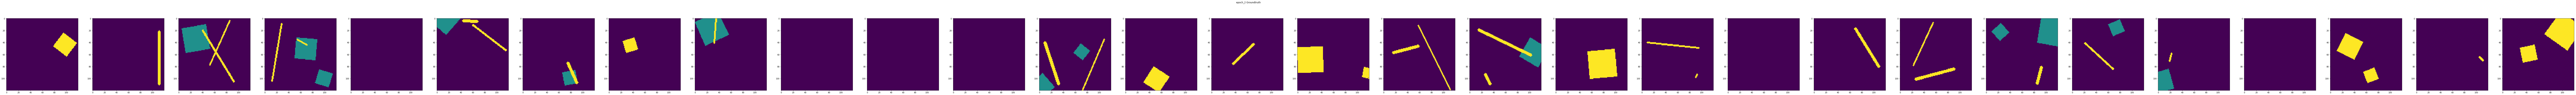

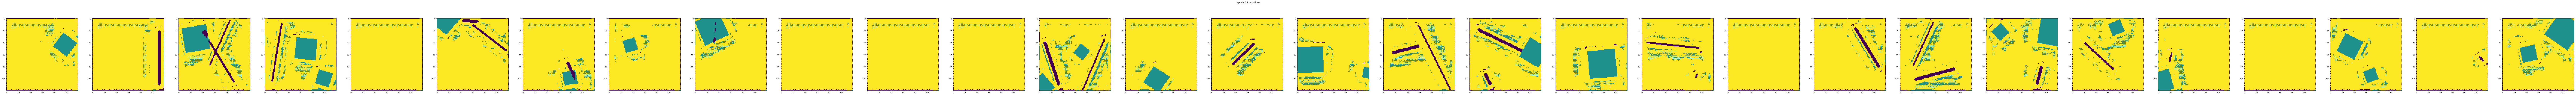

2018-03-10 19:21:43,908 Iter 1500, Minibatch Loss= 0.0496, Training Accuracy= 0.9467, Minibatch error= 5.3%
2018-03-10 19:21:47,481 Iter 1550, Minibatch Loss= 0.0466, Training Accuracy= 0.9839, Minibatch error= 1.6%
2018-03-10 19:21:51,213 Iter 1600, Minibatch Loss= 0.0604, Training Accuracy= 0.9782, Minibatch error= 2.2%
2018-03-10 19:21:54,943 Iter 1650, Minibatch Loss= 0.0383, Training Accuracy= 0.9637, Minibatch error= 3.6%
2018-03-10 19:21:58,682 Iter 1700, Minibatch Loss= 0.0468, Training Accuracy= 0.9720, Minibatch error= 2.8%
2018-03-10 19:22:03,373 Iter 1750, Minibatch Loss= 0.0492, Training Accuracy= 0.9916, Minibatch error= 0.8%
2018-03-10 19:22:07,077 Iter 1800, Minibatch Loss= 0.0523, Training Accuracy= 0.9969, Minibatch error= 0.3%
2018-03-10 19:22:10,819 Iter 1850, Minibatch Loss= 0.0345, Training Accuracy= 0.9724, Minibatch error= 2.8%
2018-03-10 19:22:14,560 Iter 1900, Minibatch Loss= 0.0319, Training Accuracy= 0.9154, Minibatch error= 8.5%
2018-03-10 19:22:18,301 Iter

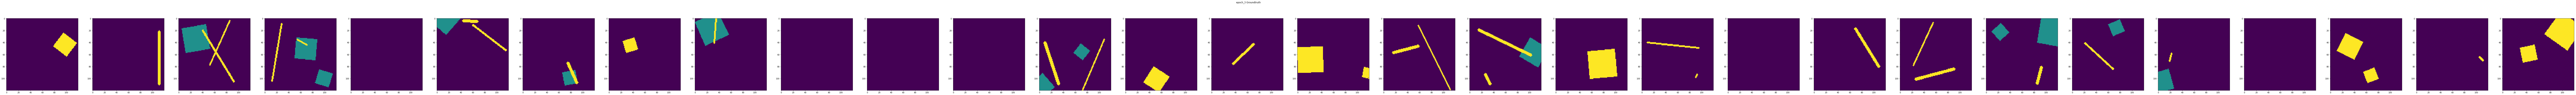

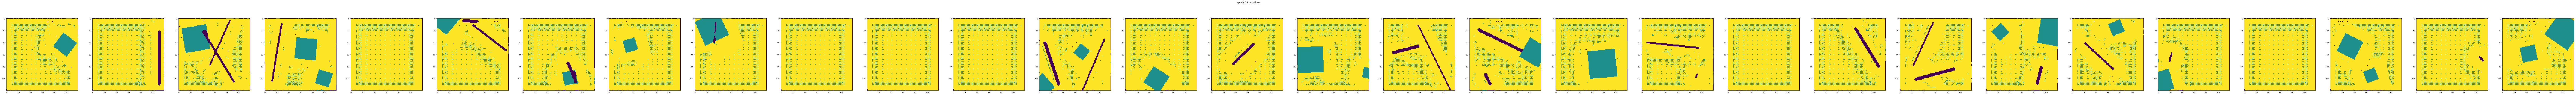

2018-03-10 19:22:31,000 Iter 2000, Minibatch Loss= 0.0361, Training Accuracy= 0.8991, Minibatch error= 10.1%
2018-03-10 19:22:34,585 Iter 2050, Minibatch Loss= 0.0676, Training Accuracy= 0.9982, Minibatch error= 0.2%
2018-03-10 19:22:38,318 Iter 2100, Minibatch Loss= 0.0502, Training Accuracy= 0.9965, Minibatch error= 0.4%
2018-03-10 19:22:42,059 Iter 2150, Minibatch Loss= 0.0571, Training Accuracy= 0.9975, Minibatch error= 0.2%
2018-03-10 19:22:45,809 Iter 2200, Minibatch Loss= 0.0337, Training Accuracy= 0.8955, Minibatch error= 10.5%
2018-03-10 19:22:50,646 Iter 2250, Minibatch Loss= 0.0565, Training Accuracy= 0.9986, Minibatch error= 0.1%
2018-03-10 19:22:54,347 Iter 2300, Minibatch Loss= 0.0814, Training Accuracy= 0.9983, Minibatch error= 0.2%
2018-03-10 19:22:58,085 Iter 2350, Minibatch Loss= 0.0534, Training Accuracy= 0.9973, Minibatch error= 0.3%
2018-03-10 19:23:01,826 Iter 2400, Minibatch Loss= 0.0466, Training Accuracy= 0.9981, Minibatch error= 0.2%
2018-03-10 19:23:05,461 Ep

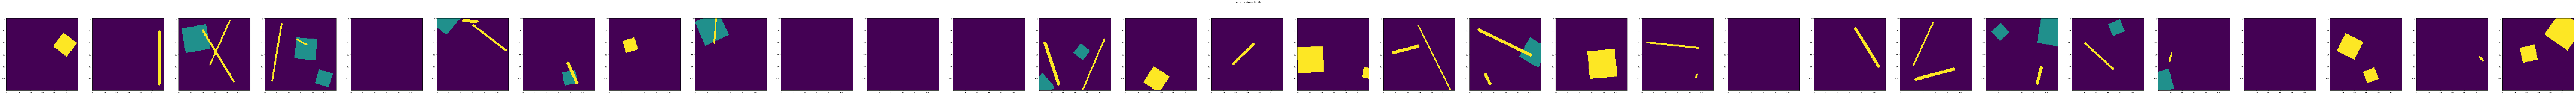

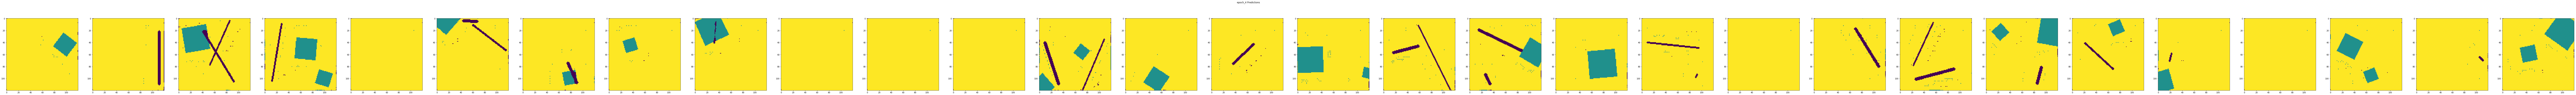

2018-03-10 19:23:13,514 Iter 2450, Minibatch Loss= 0.0506, Training Accuracy= 0.9978, Minibatch error= 0.2%
2018-03-10 19:23:17,903 Iter 2500, Minibatch Loss= 0.0457, Training Accuracy= 0.9982, Minibatch error= 0.2%
2018-03-10 19:23:21,528 Iter 2550, Minibatch Loss= 0.0469, Training Accuracy= 0.9981, Minibatch error= 0.2%
2018-03-10 19:23:25,261 Iter 2600, Minibatch Loss= 0.0412, Training Accuracy= 0.9905, Minibatch error= 0.9%
2018-03-10 19:23:28,998 Iter 2650, Minibatch Loss= 0.0665, Training Accuracy= 0.9971, Minibatch error= 0.3%
2018-03-10 19:23:32,739 Iter 2700, Minibatch Loss= 0.0559, Training Accuracy= 0.9971, Minibatch error= 0.3%
2018-03-10 19:23:37,295 Iter 2750, Minibatch Loss= 0.0543, Training Accuracy= 0.9957, Minibatch error= 0.4%
2018-03-10 19:23:41,026 Iter 2800, Minibatch Loss= 0.0427, Training Accuracy= 0.9993, Minibatch error= 0.1%
2018-03-10 19:23:44,763 Iter 2850, Minibatch Loss= 0.0415, Training Accuracy= 0.9995, Minibatch error= 0.0%
2018-03-10 19:23:48,496 Iter

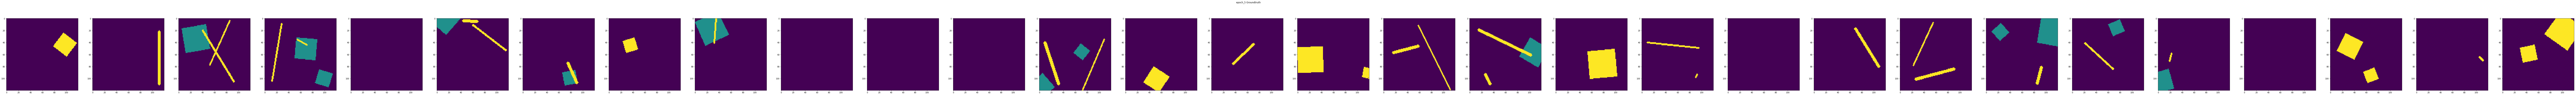

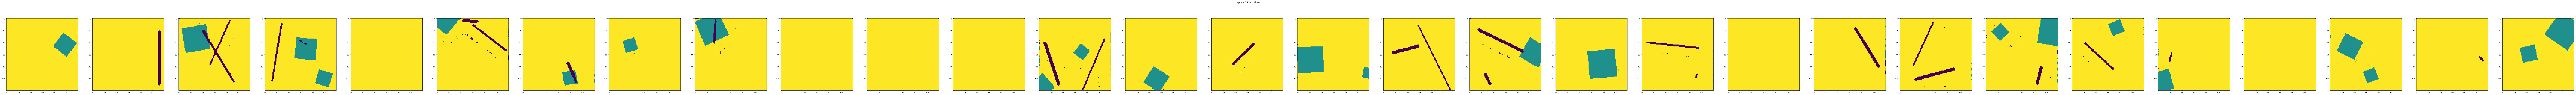

2018-03-10 19:24:00,519 Iter 2950, Minibatch Loss= 0.0433, Training Accuracy= 0.9920, Minibatch error= 0.8%
2018-03-10 19:24:04,956 Iter 3000, Minibatch Loss= 0.0436, Training Accuracy= 0.9949, Minibatch error= 0.5%
2018-03-10 19:24:08,642 Iter 3050, Minibatch Loss= 0.0478, Training Accuracy= 0.9994, Minibatch error= 0.1%
2018-03-10 19:24:12,386 Iter 3100, Minibatch Loss= 0.0465, Training Accuracy= 0.9970, Minibatch error= 0.3%
2018-03-10 19:24:16,121 Iter 3150, Minibatch Loss= 0.0456, Training Accuracy= 0.9959, Minibatch error= 0.4%
2018-03-10 19:24:19,863 Iter 3200, Minibatch Loss= 0.0462, Training Accuracy= 0.9984, Minibatch error= 0.2%
2018-03-10 19:24:24,555 Iter 3250, Minibatch Loss= 0.0396, Training Accuracy= 0.9961, Minibatch error= 0.4%
2018-03-10 19:24:28,279 Iter 3300, Minibatch Loss= 0.0612, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:24:32,030 Iter 3350, Minibatch Loss= 0.0517, Training Accuracy= 0.9984, Minibatch error= 0.2%
2018-03-10 19:24:35,763 Iter

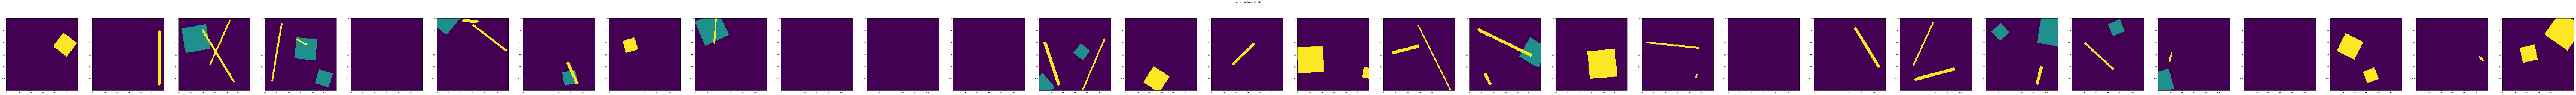

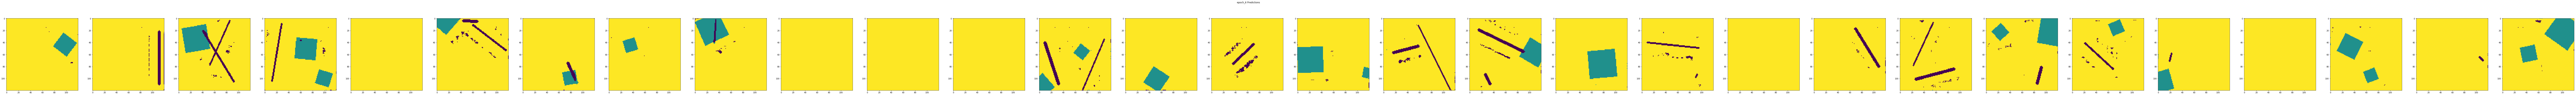

2018-03-10 19:24:47,601 Iter 3450, Minibatch Loss= 0.0418, Training Accuracy= 0.9962, Minibatch error= 0.4%
2018-03-10 19:24:52,079 Iter 3500, Minibatch Loss= 0.0539, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:24:55,797 Iter 3550, Minibatch Loss= 0.0426, Training Accuracy= 0.9995, Minibatch error= 0.1%
2018-03-10 19:24:59,535 Iter 3600, Minibatch Loss= 0.0403, Training Accuracy= 0.9995, Minibatch error= 0.0%
2018-03-10 19:25:03,265 Iter 3650, Minibatch Loss= 0.0381, Training Accuracy= 0.9987, Minibatch error= 0.1%
2018-03-10 19:25:07,005 Iter 3700, Minibatch Loss= 0.0475, Training Accuracy= 0.9968, Minibatch error= 0.3%
2018-03-10 19:25:11,598 Iter 3750, Minibatch Loss= 0.0491, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-03-10 19:25:15,323 Iter 3800, Minibatch Loss= 0.0310, Training Accuracy= 0.9989, Minibatch error= 0.1%
2018-03-10 19:25:19,060 Iter 3850, Minibatch Loss= 0.0582, Training Accuracy= 0.9983, Minibatch error= 0.2%
2018-03-10 19:25:22,801 Iter

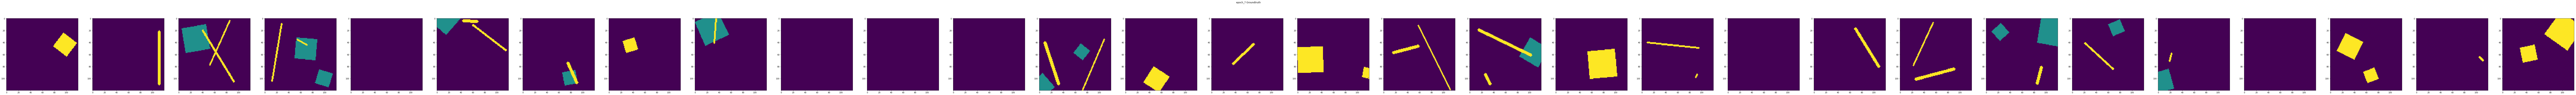

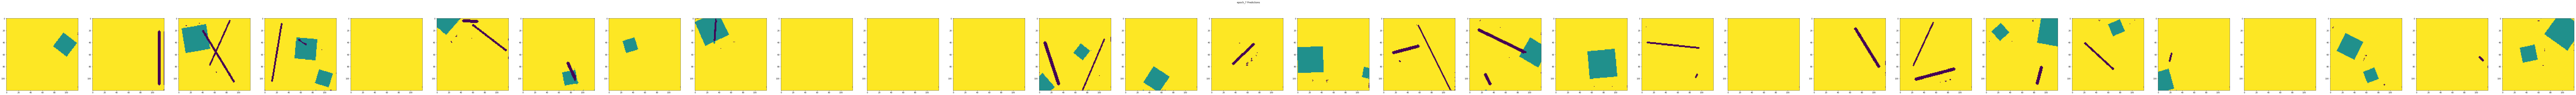

2018-03-10 19:25:34,218 Iter 3950, Minibatch Loss= 0.0495, Training Accuracy= 0.9936, Minibatch error= 0.6%
2018-03-10 19:25:38,913 Iter 4000, Minibatch Loss= 0.0459, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:25:42,633 Iter 4050, Minibatch Loss= 0.0596, Training Accuracy= 0.9995, Minibatch error= 0.0%
2018-03-10 19:25:46,360 Iter 4100, Minibatch Loss= 0.0379, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:25:50,103 Iter 4150, Minibatch Loss= 0.0464, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:25:53,848 Iter 4200, Minibatch Loss= 0.0473, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:25:58,703 Iter 4250, Minibatch Loss= 0.0514, Training Accuracy= 0.9994, Minibatch error= 0.1%
2018-03-10 19:26:02,418 Iter 4300, Minibatch Loss= 0.0345, Training Accuracy= 0.9957, Minibatch error= 0.4%
2018-03-10 19:26:06,148 Iter 4350, Minibatch Loss= 0.0312, Training Accuracy= 0.9960, Minibatch error= 0.4%
2018-03-10 19:26:09,886 Iter

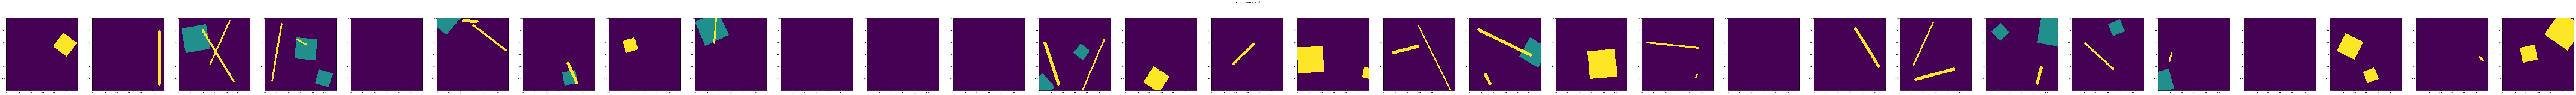

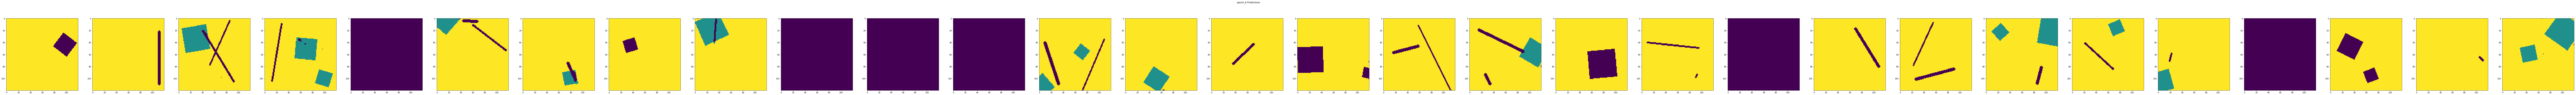

2018-03-10 19:26:21,942 Iter 4450, Minibatch Loss= 0.0357, Training Accuracy= 0.9975, Minibatch error= 0.3%
2018-03-10 19:26:26,600 Iter 4500, Minibatch Loss= 0.0671, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-03-10 19:26:30,307 Iter 4550, Minibatch Loss= 0.0497, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:26:34,045 Iter 4600, Minibatch Loss= 0.0563, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:26:37,788 Iter 4650, Minibatch Loss= 0.0335, Training Accuracy= 0.9986, Minibatch error= 0.1%
2018-03-10 19:26:41,529 Iter 4700, Minibatch Loss= 0.0561, Training Accuracy= 0.9995, Minibatch error= 0.1%
2018-03-10 19:26:46,084 Iter 4750, Minibatch Loss= 0.0810, Training Accuracy= 0.9994, Minibatch error= 0.1%
2018-03-10 19:26:49,817 Iter 4800, Minibatch Loss= 0.0519, Training Accuracy= 0.9987, Minibatch error= 0.1%
2018-03-10 19:26:53,564 Iter 4850, Minibatch Loss= 0.0465, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:26:57,194 Epoc

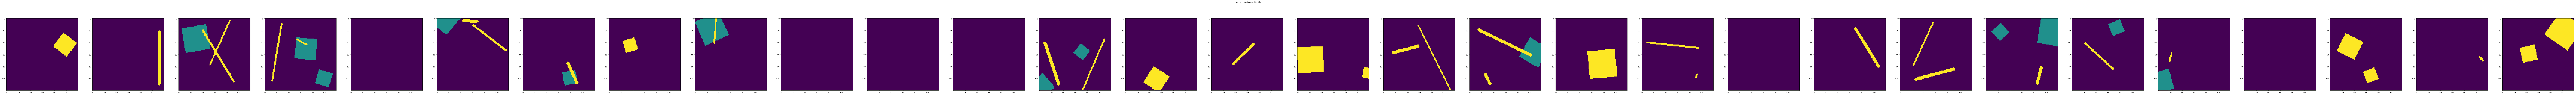

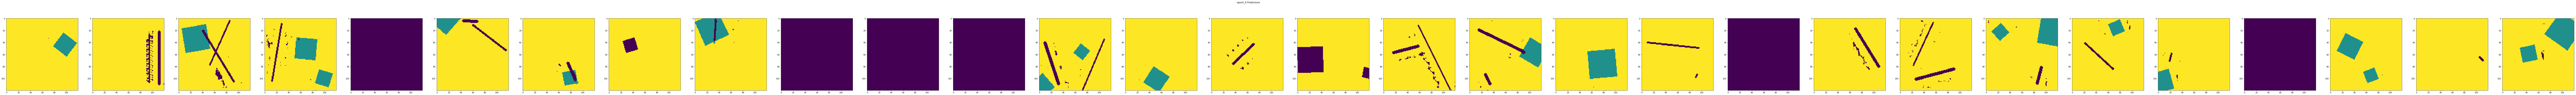

2018-03-10 19:27:06,309 Iter 4900, Minibatch Loss= 0.0495, Training Accuracy= 0.9995, Minibatch error= 0.1%
2018-03-10 19:27:09,858 Iter 4950, Minibatch Loss= 0.0453, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:27:14,410 Iter 5000, Minibatch Loss= 0.0468, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:27:18,129 Iter 5050, Minibatch Loss= 0.0412, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:27:21,869 Iter 5100, Minibatch Loss= 0.0655, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:27:25,611 Iter 5150, Minibatch Loss= 0.0558, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:27:29,351 Iter 5200, Minibatch Loss= 0.0541, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:27:33,974 Iter 5250, Minibatch Loss= 0.0425, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:27:37,715 Iter 5300, Minibatch Loss= 0.0414, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:27:41,458 Iter

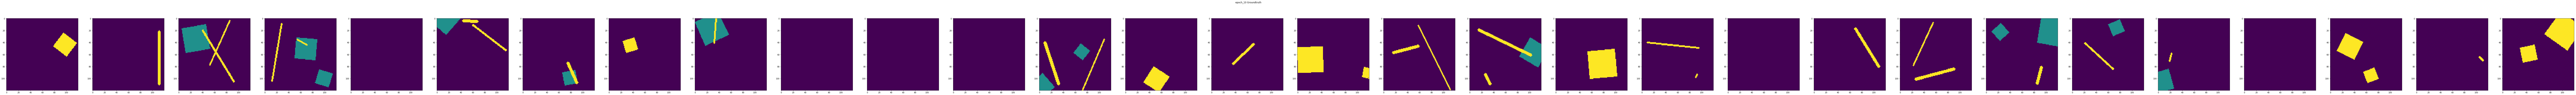

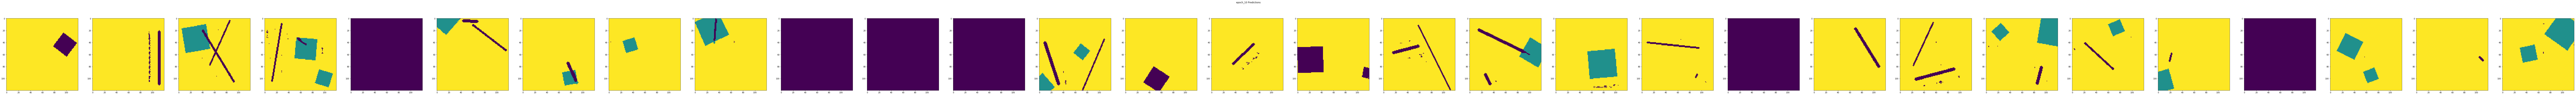

2018-03-10 19:27:53,336 Iter 5400, Minibatch Loss= 0.0431, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:27:56,890 Iter 5450, Minibatch Loss= 0.0436, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:28:01,561 Iter 5500, Minibatch Loss= 0.0478, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-03-10 19:28:05,274 Iter 5550, Minibatch Loss= 0.0451, Training Accuracy= 0.9995, Minibatch error= 0.1%
2018-03-10 19:28:09,010 Iter 5600, Minibatch Loss= 0.0456, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:28:12,747 Iter 5650, Minibatch Loss= 0.0460, Training Accuracy= 0.9995, Minibatch error= 0.0%
2018-03-10 19:28:16,492 Iter 5700, Minibatch Loss= 0.0385, Training Accuracy= 0.9994, Minibatch error= 0.1%
2018-03-10 19:28:21,099 Iter 5750, Minibatch Loss= 0.0612, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:28:24,836 Iter 5800, Minibatch Loss= 0.0516, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:28:28,577 Iter

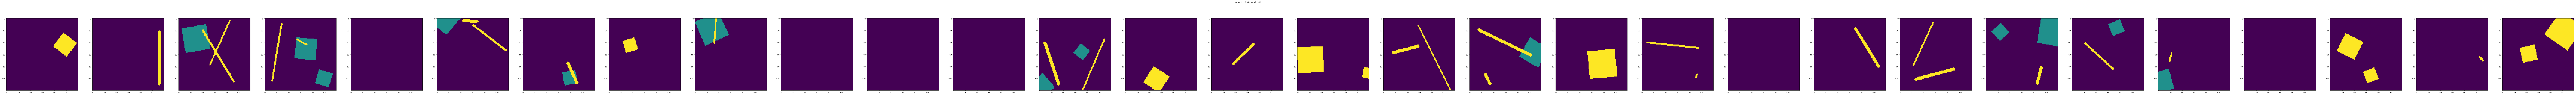

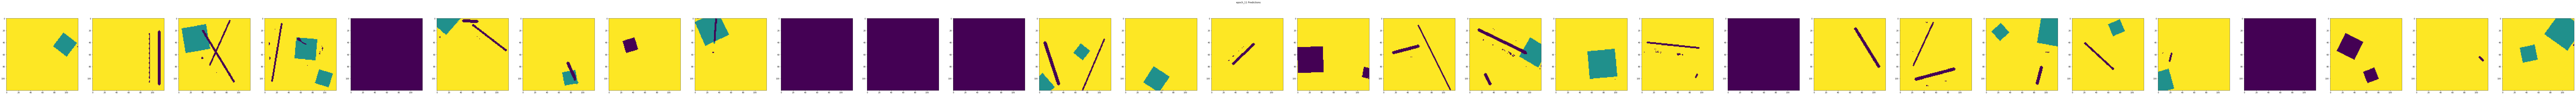

2018-03-10 19:28:40,211 Iter 5900, Minibatch Loss= 0.0416, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:28:43,788 Iter 5950, Minibatch Loss= 0.0538, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-03-10 19:28:48,440 Iter 6000, Minibatch Loss= 0.0425, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:28:52,153 Iter 6050, Minibatch Loss= 0.0403, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:28:55,894 Iter 6100, Minibatch Loss= 0.0379, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:28:59,629 Iter 6150, Minibatch Loss= 0.0474, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:29:03,364 Iter 6200, Minibatch Loss= 0.0488, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:29:08,241 Iter 6250, Minibatch Loss= 0.0307, Training Accuracy= 0.9991, Minibatch error= 0.1%
2018-03-10 19:29:11,961 Iter 6300, Minibatch Loss= 0.0574, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:29:15,699 Iter

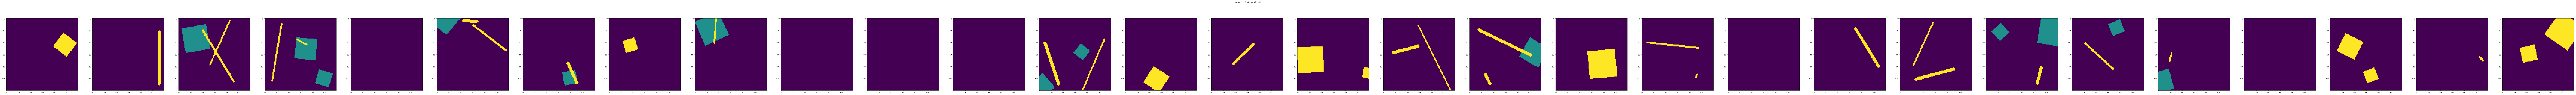

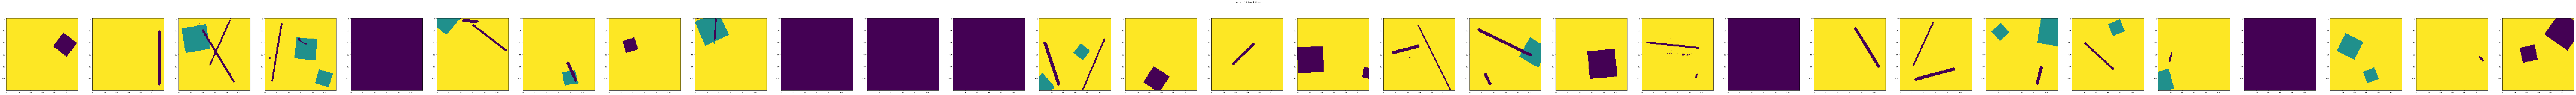

2018-03-10 19:29:27,747 Iter 6400, Minibatch Loss= 0.0495, Training Accuracy= 0.9987, Minibatch error= 0.1%
2018-03-10 19:29:31,362 Iter 6450, Minibatch Loss= 0.0458, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:29:35,992 Iter 6500, Minibatch Loss= 0.0594, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:29:39,707 Iter 6550, Minibatch Loss= 0.0379, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-03-10 19:29:43,438 Iter 6600, Minibatch Loss= 0.0463, Training Accuracy= 0.9987, Minibatch error= 0.1%
2018-03-10 19:29:47,176 Iter 6650, Minibatch Loss= 0.0472, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:29:50,922 Iter 6700, Minibatch Loss= 0.0513, Training Accuracy= 0.9995, Minibatch error= 0.1%
2018-03-10 19:29:55,441 Iter 6750, Minibatch Loss= 0.0345, Training Accuracy= 0.9998, Minibatch error= 0.0%
2018-03-10 19:29:59,176 Iter 6800, Minibatch Loss= 0.0312, Training Accuracy= 0.9990, Minibatch error= 0.1%
2018-03-10 19:30:02,923 Iter

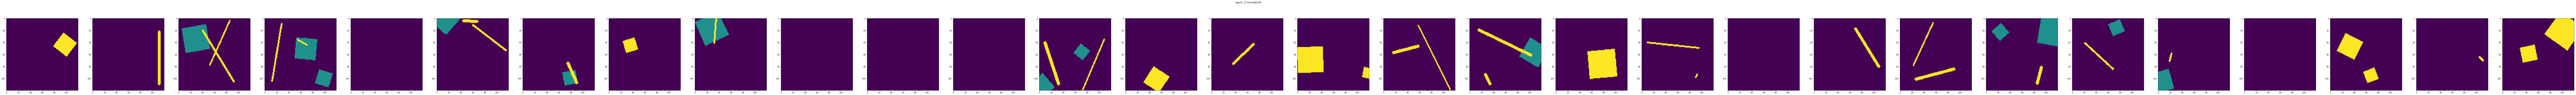

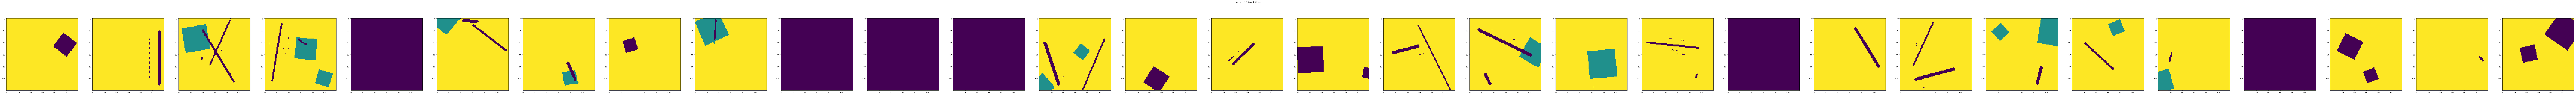

2018-03-10 19:30:14,903 Iter 6900, Minibatch Loss= 0.0357, Training Accuracy= 0.9987, Minibatch error= 0.1%
2018-03-10 19:30:18,558 Iter 6950, Minibatch Loss= 0.0667, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:30:23,050 Iter 7000, Minibatch Loss= 0.0497, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-03-10 19:30:26,778 Iter 7050, Minibatch Loss= 0.0560, Training Accuracy= 0.9996, Minibatch error= 0.0%
2018-03-10 19:30:30,524 Iter 7100, Minibatch Loss= 0.0333, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:30:34,259 Iter 7150, Minibatch Loss= 0.0560, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:30:37,999 Iter 7200, Minibatch Loss= 0.0809, Training Accuracy= 0.9999, Minibatch error= 0.0%
2018-03-10 19:30:42,697 Iter 7250, Minibatch Loss= 0.0517, Training Accuracy= 0.9997, Minibatch error= 0.0%
2018-03-10 19:30:46,420 Iter 7300, Minibatch Loss= 0.0465, Training Accuracy= 0.9992, Minibatch error= 0.1%
2018-03-10 19:30:50,059 Epoc

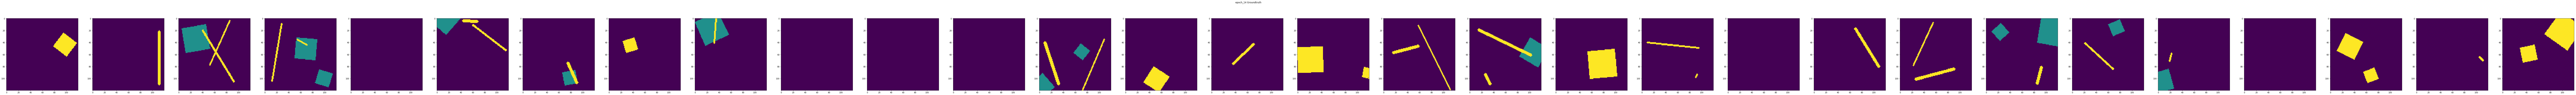

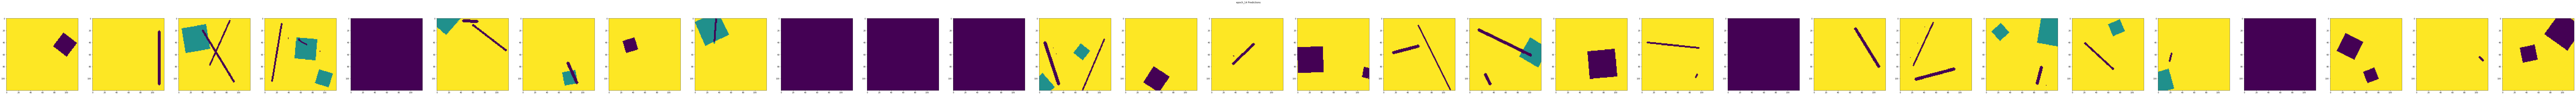

2018-03-10 19:30:58,311 Optimization Finished!


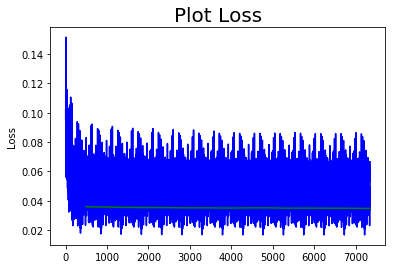

In [21]:
if __name__ == '__main__':
    model = CustomCNN()


#     root_folder = '../DATA_GHANA/DATASET/120_x_120_8_bands/'
    root_folder=''
    trainer=Trainer(model,DEFAULT_BATCH_SIZE)
    save_path,loss_train,loss_verif=trainer.train( root_folder, MODEL_PATH_SAVE, '', DEFAULT_ITERATIONS,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,False,REC_SAVE, TEST_SAVE)
    
    #SAVE PSNR
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,DEFAULT_EPOCHS*DEFAULT_ITERATIONS,1)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')
    plt.show()
    
    